In [59]:
#  데이터 처리 모듈
import pandas as pd
from sklearn.impute import KNNImputer
# 행렬 등 통계 연산 모듈
import numpy as np
# 지수형 표기법 e를 연속형 변환
pd.options.display.float_format = '{:.4f}'.format
# 타입 어노테이션(Any, Sequence 등의 메서드 활용)
from typing import *
import os

# 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")
import os

# 조합 찾는 반복문 메서드
from itertools import permutations
from itertools import combinations

# 데이터 시각화
import matplotlib.pyplot as plt
# from matplotlib.pyplot import
import matplotlib.font_manager as fm
import missingno as msno
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')
# 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)
# Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})
# 폰트 설정

### 1.한국신용데이터(KCD) 서울특별시 소상공인(SOHO)의 신용거래정보 추출 데이터를 활용한 파생변수 생성

* **credit_data_list**
  
  2022년 1월 ~ 2023년 3월 15개월의 서울특별시 소상공인 상권별 업종별 신용거래 및 사업장정보 데이터프레임을 담은 리스트 반환

* **변동계수(coefficient of variation, CV)**
  
  표준편차를 산술평균을 기준으로 표준화(standardization)한 것으로, 표준편차를 산술평균으로 나눈 값

  같은 단위를 가지는 표준편차를 평균으로 나누면, 단위가 사라지고 표준화된 수치를 비교

In [2]:
class MergeData():

  def __init__(self, soho_credit_data = None):
    self.soho_credit_data = soho_credit_data

  def mergeSohoCredit(self, date_time1: int, date_time2: int,
                      file_path: str, file_name: str,
                      column_num:int, column_name_list: List):
    # date_time에 202201 ~ 202212, 202301 ~ 202303을 입력값으로 받고,
    # file_path에 해당 데이터가 있는 드라이브 경로 설정
    # file_path = /content/drive/MyDrive/2023BigContest/Archive/"

    credit_data_list: List = []
      # 월별 데이터프레임을 담을 리스트 생성
    date_time_list = [str(date_time1 + n) for n in range(0, 12, 1)]
    date_time_list.extend([str(date_time2 + n) for n in range(0, 3, 1)])

    for date in date_time_list:
      data = pd.read_csv(
          os.path.join(file_path + date + file_name),
          index_col = 0, sep = ",",
          names = column_name_list)
          # header = None)
      data.drop("index", axis = 0, inplace = True)
      data[column_name_list[column_num:]] = data[column_name_list[column_num:]].astype("float")

      def mutateUniqueID(column_상권명, column_업종중분류):
        상권_식별자 = column_상권명
        if not pd.isna(column_업종중분류):
          상권_식별자 += "_" + str(column_업종중분류)
        return 상권_식별자
      data["상권_식별자"] = data.apply(
          lambda x: mutateUniqueID(x["상권명"], x["외식업종_중분류"]), axis = 1)

      credit_data_list.append(data)
        # os.path.join을 통한 구글 드라이브 파일 내 경로로 csv데이터 로드하여 판다스 데이터프레임으로 저장 후
        # credit_data_list에 0 ~ 11번째 인덱스의 원소로 추가

    return credit_data_list
      # 2022년 1월 ~ 2023년 3월 15개월의 서울특별시 소상공인 상권별 업종별 신용거래 및 사업장정보 데이터프레임을 담은 리스트 반환
      # 병합하여 self.soho_credit_data라는 멤버변수에 저장할 것

In [3]:
Preprocess = MergeData()

---

#### [SOHO_INCOME_DATA_LIST] 소호 신용거래정보 매출액(카드 + 배달), 매입액(카드 + 현금), 객단가, 부가가치세, 손익분기점 등 파생변수 생성

In [4]:
SOHO_INCOME_DATA_LIST = Preprocess.mergeSohoCredit(
    date_time1 = 202201,
    date_time2 = 202301,
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/SOHO_INCOME/SOHO_",
    file_name = "_INCOME_230916.csv",
    column_name_list = ["상권명", "상권코드", "외식업종_중분류",
                        "매출액_표준편차", "매입액_표준편차", "매출총이익_표준편차", "부가가치세_표준편차", "부가세차감전영업이익_표준편차", "영업이익_표준편차",
                        "주말매출액_표준편차", "사업장방문고객수_표준편차", "사업장방문신규고객수_표준편차",
                        "배달매출액_표준편차", "주말배달매출액_표준편차", "카드매출액_표준편차", "주말카드매출액_표준편차"],
    column_num = 3)

In [5]:
SOHO_INCOME_DATA_LIST[0].info()
SOHO_INCOME_DATA_LIST[0]

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, 0 to 169
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   상권명              170 non-null    object 
 1   상권코드             170 non-null    object 
 2   외식업종_중분류         170 non-null    object 
 3   매출액_표준편차         170 non-null    float64
 4   매입액_표준편차         170 non-null    float64
 5   매출총이익_표준편차       170 non-null    float64
 6   부가가치세_표준편차       170 non-null    float64
 7   부가세차감전영업이익_표준편차  170 non-null    float64
 8   영업이익_표준편차        170 non-null    float64
 9   주말매출액_표준편차       170 non-null    float64
 10  사업장방문고객수_표준편차    170 non-null    float64
 11  사업장방문신규고객수_표준편차  170 non-null    float64
 12  배달매출액_표준편차       154 non-null    float64
 13  주말배달매출액_표준편차     155 non-null    float64
 14  카드매출액_표준편차       170 non-null    float64
 15  주말카드매출액_표준편차     170 non-null    float64
 16  상권_식별자           170 non-null    object 
dtypes: float64(13), objec

,상권명,상권코드,외식업종_중분류,매출액_표준편차,매입액_표준편차,매출총이익_표준편차,부가가치세_표준편차,부가세차감전영업이익_표준편차,영업이익_표준편차,주말매출액_표준편차,사업장방문고객수_표준편차,사업장방문신규고객수_표준편차,배달매출액_표준편차,주말배달매출액_표준편차,카드매출액_표준편차,주말카드매출액_표준편차,상권_식별자
0,DMC(디지털미디어시티),2120098,카페,7.6766,9.8450,9.2697,6.1576,9.1012,12.2121,1.7788,20.5596,3.3266,1.3972,0.4727,7.1460,1.6387,DMC(디지털미디어시티)_카페
1,가락시장역,2120234,한식,42.4509,2.4112,40.1029,14.5653,38.4800,52.3236,13.6707,5.1309,3.3644,13.0019,3.8753,40.6344,13.1709,가락시장역_한식
2,가로수길,2120186,술집,25.2326,2.7855,22.7759,16.4136,18.8498,34.8480,9.1549,6.0430,5.4239,0.1032,0.0003,25.2479,9.1549,가로수길_술집
3,가로수길,2120186,일식,25.1656,4.1835,21.5091,14.7552,20.4437,34.7004,6.2320,5.9381,5.3513,5.4961,1.7954,24.5104,5.7937,가로수길_일식
4,가로수길,2120186,한식,32.0864,5.1861,28.5434,13.9835,27.9569,41.7216,14.6776,7.8539,4.9931,NaN,0.0001,32.0864,14.6776,가로수길_한식
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,홍대입구역(홍대),2120103,술집,17.1917,4.6868,14.8453,8.6443,13.9571,21.2448,8.6566,5.1295,3.1077,4.6054,1.5848,16.5957,8.5754,홍대입구역(홍대)_술집
166,홍대입구역(홍대),2120103,양식,13.9643,4.6967,11.5457,7.1460,11.0079,17.2400,7.6980,4.3672,3.7124,6.0419,1.7960,15.9077,8.3580,홍대입구역(홍대)_양식
167,홍대입구역(홍대),2120103,일식,25.0619,2.1534,24.7404,11.7960,23.7480,35.2854,11.0322,4.6525,4.4150,1.8310,0.5501,24.4990,10.8036,홍대입구역(홍대)_일식
168,홍대입구역(홍대),2120103,카페,8.7291,10.3860,10.0852,5.0957,10.0579,10.9291,4.7151,6.4867,6.0599,0.0122,0.0001,8.7267,4.7151,홍대입구역(홍대)_카페


```
* standard_deviation_population(kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery)
* standard_deviation_population(kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash)
* standard_deviation_population((kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery) - (kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash))
* standard_deviation_population(kcd.transactions.sum_sales_invoice - kcd.transactions.sum_purchase_invoice)
* standard_deviation_population(((kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery) - (kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash)) - kcd.transactions.monthly_rental_fee)
* standard_deviation_population((((kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery) - (kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash)) - kcd.transactions.monthly_rental_fee) - (kcd.transactions.sum_sales_invoice - kcd.transactions.sum_purchase_invoice))
* standard_deviation_population(kcd.transactions.sum_weekend_sales_card + kcd.transactions.sum_weekend_sales_delivery)
* standard_deviation_population(sum_customer_cnt)
* standard_deviation_population(sum_new_customer_cnt)
* STANDARD_DEVIATION_POPULATION(kcd.transactions.sum_sales_delivery)
* STANDARD_DEVIATION_POPULATION(kcd.transactions.sum_weekend_sales_delivery)
* STANDARD_DEVIATION_POPULATION(kcd.transactions.sum_sales_card)
* STANDARD_DEVIATION_POPULATION(kcd.transactions.sum_weekend_sales_card)
```


---

#### [SOHO_BUSINESS_DATA_LIST] 소호 임대동향, 사업장 정보

In [6]:
SOHO_BUSINESS_DATA_LIST = Preprocess.mergeSohoCredit(
    date_time1 = 202201,
    date_time2 = 202301,
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/SOHO_BUSINESS/SOHO_",
    file_name = "_BUSINESS_230911.csv",
    column_name_list = ["상권명", "외식업종_중분류",
                        "소호사업장_수", "경영위기사업장_총합", "프랜차이즈사업장_총합", "소상공인연령_평균", "소상공인업력_평균"],
    column_num = 2)

In [7]:
SOHO_BUSINESS_DATA_LIST[0].info()
SOHO_BUSINESS_DATA_LIST[0]

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   상권명          172 non-null    object 
 1   외식업종_중분류     172 non-null    object 
 2   소호사업장_수      172 non-null    float64
 3   경영위기사업장_총합   172 non-null    float64
 4   프랜차이즈사업장_총합  172 non-null    float64
 5   소상공인연령_평균    172 non-null    float64
 6   소상공인업력_평균    172 non-null    float64
 7   상권_식별자       172 non-null    object 
dtypes: float64(5), object(3)
memory usage: 12.1+ KB


,상권명,외식업종_중분류,소호사업장_수,경영위기사업장_총합,프랜차이즈사업장_총합,소상공인연령_평균,소상공인업력_평균,상권_식별자
0,DMC(디지털미디어시티),카페,13.0000,0.0000,3.0000,39.5846,5.2692,DMC(디지털미디어시티)_카페
1,가락시장역,한식,5.0000,0.0000,3.0000,44.9400,5.8400,가락시장역_한식
2,가로수길,술집,7.0000,0.0000,1.0000,42.3571,5.9000,가로수길_술집
3,가로수길,일식,7.0000,0.0000,1.0000,34.6571,3.5714,가로수길_일식
4,가로수길,한식,7.0000,0.0000,2.0000,41.9143,4.6429,가로수길_한식
...,...,...,...,...,...,...,...,...
167,홍대입구역(홍대),술집,42.0000,0.0000,2.0000,41.2619,4.5667,홍대입구역(홍대)_술집
168,홍대입구역(홍대),양식,11.0000,0.0000,2.0000,38.3364,5.6727,홍대입구역(홍대)_양식
169,홍대입구역(홍대),일식,6.0000,0.0000,0.0000,42.2500,3.6333,홍대입구역(홍대)_일식
170,홍대입구역(홍대),카페,13.0000,0.0000,0.0000,36.4846,5.5923,홍대입구역(홍대)_카페


```
* COUNT(*)
* SUM(kcd.transactions.is_risky)
* SUM(kcd.meta-info.is_franchise)
* AVERAGE(kcd.meta-info.age)
* AVERAGE(kcd.meta-info.duration)
```

* ValueError: could not convert string to float: 'DMC(디지털미디어시티)'

---

#### [SOHO_METAINFO_DATA_LIST] 소호 개인사업자 업력, 연령, 경영위기 FLAG, 프랜차이즈(브랜드) TF


In [8]:
SOHO_METAINFO_DATA_LIST = Preprocess.mergeSohoCredit(
    date_time1 = 202201,
    date_time2 = 202301,
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/SOHO_METAINFO/SOHO_",
    file_name = "_METAINFO_230911.csv",
    column_name_list = ["상권명", "외식업종_중분류",
                        "정규고용인원_평균", "사업장방문고객수_평균", "사업장방문신규고객수_평균", "사업장임대면적_표준편차", "월임대료_표준편차", "임대보증금_표준편차"],
    column_num = 2)

In [9]:
SOHO_METAINFO_DATA_LIST[0].info()
SOHO_METAINFO_DATA_LIST[0]

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, 0 to 169
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   상권명            170 non-null    object 
 1   외식업종_중분류       170 non-null    object 
 2   정규고용인원_평균      170 non-null    float64
 3   사업장방문고객수_평균    170 non-null    float64
 4   사업장방문신규고객수_평균  170 non-null    float64
 5   사업장임대면적_표준편차   170 non-null    float64
 6   월임대료_표준편차      170 non-null    float64
 7   임대보증금_표준편차     170 non-null    float64
 8   상권_식별자         170 non-null    object 
dtypes: float64(6), object(3)
memory usage: 13.3+ KB


,상권명,외식업종_중분류,정규고용인원_평균,사업장방문고객수_평균,사업장방문신규고객수_평균,사업장임대면적_표준편차,월임대료_표준편차,임대보증금_표준편차,상권_식별자
0,DMC(디지털미디어시티),카페,0.8292,29.1015,6.6692,14.0824,1.0078,2.3026,DMC(디지털미디어시티)_카페
1,가락시장역,한식,2.3500,4.9360,3.3360,50.2651,2.2517,3.4986,가락시장역_한식
2,가로수길,술집,5.2500,3.3886,2.9971,59.3748,4.1031,6.6701,가로수길_술집
3,가로수길,일식,4.3857,6.6600,5.9857,60.2966,1.3120,2.7572,가로수길_일식
4,가로수길,한식,3.9514,9.8900,6.4200,44.4870,1.0782,1.8295,가로수길_한식
...,...,...,...,...,...,...,...,...,...
165,홍대입구역(홍대),술집,0.7488,4.5225,3.3048,58.2630,1.7285,2.7087,홍대입구역(홍대)_술집
166,홍대입구역(홍대),양식,1.1209,6.1436,4.8255,58.1593,0.8608,1.3499,홍대입구역(홍대)_양식
167,홍대입구역(홍대),일식,1.6533,5.2933,4.8867,70.6558,3.6545,3.2713,홍대입구역(홍대)_일식
168,홍대입구역(홍대),카페,1.2692,10.7162,7.7131,61.4603,1.2972,7.4799,홍대입구역(홍대)_카페


```
* AVERAGE(kcd.transactions.regular_employees_count)
* AVERAGE(kcd.transactions.sum_customer_cnt)
* AVERAGE(kcd.transactions.sum_new_customer_cnt)
* STANDARD_DEVIATION_POPULATION(kcd.transactions.business_square_size)
* STANDARD_DEVIATION_POPULATION(kcd.transactions.monthly_rental_fee)
* STANDARD_DEVIATION_POPULATION(kcd.transactions.rental_deposit)


---

#### [SOHO_STANDARDIZATION_DATA_LIST] 변동계수(coefficient of variation, CV) 산출을 위한 평균 연산

In [10]:
SOHO_STANDARDIZATION_DATA_LIST = Preprocess.mergeSohoCredit(
    date_time1 = 202201,
    date_time2 = 202301,
    file_path = "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/SOHO_STANDARDIZATION/SOHO_",
    file_name = "_STANDARDIZATION_230916.csv",
    column_name_list = ["상권명", "상권코드", "외식업종_중분류",
                        "매출액_평균", "매입액_평균", "매출총이익_평균", "부가가치세_평균", "부가세차감전영업이익_평균", "영업이익_평균",
                        "주말매출액_평균", "사업장방문고객수_평균", "사업장방문신규고객수_평균",
                        "배달매출액_평균", "주말배달매출액_평균", "카드매출액_평균", "주말카드매출액_평균",
                        "사업장임대면적_평균", "월임대료_평균", "임대보증금_평균"],
    column_num = 3)

In [11]:
SOHO_STANDARDIZATION_DATA_LIST[0].info()
SOHO_STANDARDIZATION_DATA_LIST[0]

<class 'pandas.core.frame.DataFrame'>
Index: 170 entries, 0 to 169
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   상권명            170 non-null    object 
 1   상권코드           170 non-null    object 
 2   외식업종_중분류       170 non-null    object 
 3   매출액_평균         170 non-null    float64
 4   매입액_평균         170 non-null    float64
 5   매출총이익_평균       170 non-null    float64
 6   부가가치세_평균       170 non-null    float64
 7   부가세차감전영업이익_평균  170 non-null    float64
 8   영업이익_평균        170 non-null    float64
 9   주말매출액_평균       170 non-null    float64
 10  사업장방문고객수_평균    170 non-null    float64
 11  사업장방문신규고객수_평균  170 non-null    float64
 12  배달매출액_평균       170 non-null    float64
 13  주말배달매출액_평균     170 non-null    float64
 14  카드매출액_평균       170 non-null    float64
 15  주말카드매출액_평균     170 non-null    float64
 16  사업장임대면적_평균     170 non-null    float64
 17  월임대료_평균        170 non-null    float64
 18  임대보증금_평균       

,상권명,상권코드,외식업종_중분류,매출액_평균,매입액_평균,매출총이익_평균,부가가치세_평균,부가세차감전영업이익_평균,영업이익_평균,주말매출액_평균,사업장방문고객수_평균,사업장방문신규고객수_평균,배달매출액_평균,주말배달매출액_평균,카드매출액_평균,주말카드매출액_평균,사업장임대면적_평균,월임대료_평균,임대보증금_평균,상권_식별자
0,DMC(디지털미디어시티),2120098,카페,15.3962,5.7894,9.6068,-8.8020,7.7199,16.5218,1.4247,29.1015,6.6692,0.6481,0.1842,14.7481,1.2404,34.1172,1.8869,4.0769,DMC(디지털미디어시티)_카페
1,가락시장역,2120234,한식,41.3209,4.1791,37.1418,-18.8620,33.1538,52.0159,11.3322,4.9360,3.3360,7.0888,2.0076,34.2321,9.3246,95.7500,3.9880,6.1000,가락시장역_한식
2,가로수길,2120186,술집,17.4297,3.1389,14.2908,-12.5042,10.3037,22.8079,5.6699,3.3886,2.9971,0.0421,-0.0000,17.3875,5.6699,111.4814,3.9871,5.7143,가로수길_술집
3,가로수길,2120186,일식,51.3019,6.4147,44.8872,-22.2104,41.2729,63.4833,15.6342,6.6600,5.9857,2.2438,0.7330,49.0582,14.9012,95.7729,3.6143,6.0714,가로수길_일식
4,가로수길,2120186,한식,53.2927,8.3375,44.9552,-23.5541,40.5745,64.1286,14.3511,9.8900,6.4200,-0.0000,0.0000,53.2927,14.3511,128.8971,4.3807,5.7143,가로수길_한식
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,홍대입구역(홍대),2120103,술집,17.4317,4.4062,13.0254,-8.3576,10.0492,18.4068,8.2248,4.5225,3.3048,0.9402,0.3337,16.4914,7.8911,100.7072,2.9762,4.2286,홍대입구역(홍대)_술집
166,홍대입구역(홍대),2120103,양식,25.2352,6.9896,18.2456,-12.6493,15.7593,28.4086,10.1121,6.1436,4.8255,5.1613,1.2896,20.0740,8.8226,64.9740,2.4864,3.1364,홍대입구역(홍대)_양식
167,홍대입구역(홍대),2120103,일식,28.5892,4.0903,24.4990,-14.9009,20.0073,34.9082,12.2560,5.2933,4.8867,0.8353,0.2460,27.7540,12.0100,104.8970,4.4917,4.5833,홍대입구역(홍대)_일식
168,홍대입구역(홍대),2120103,카페,11.3882,5.9623,5.4259,-4.4525,3.2367,7.6892,5.3395,10.7162,7.7131,0.0035,0.0000,11.3847,5.3395,81.3211,2.1892,4.7077,홍대입구역(홍대)_카페


```
 * AVERAGE(kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery)
 * AVERAGE(kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash)
 * AVERAGE((kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery) - (kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash))
 * AVERAGE(kcd.transactions.sum_sales_invoice - kcd.transactions.sum_purchase_invoice)
 * AVERAGE(((kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery) - (kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash)) - kcd.transactions.monthly_rental_fee)
 * AVERAGE((((kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery) - (kcd.transactions.sum_purchase_card + kcd.transactions.sum_purchase_cash)) - kcd.transactions.monthly_rental_fee) - (kcd.transactions.sum_sales_invoice - kcd.transactions.sum_purchase_invoice))
 * AVERAGE(kcd.transactions.sum_weekend_sales_card + kcd.transactions.sum_weekend_sales_delivery)
 * AVERAGE(kcd.transactions.sum_customer_cnt)
 * AVERAGE(kcd.transactions.sum_new_customer_cnt)
 * AVERAGE(kcd.transactions.sum_sales_delivery)
 * AVERAGE(kcd.transactions.sum_weekend_sales_delivery)
 * AVERAGE(kcd.transactions.sum_sales_card)
 * AVERAGE(kcd.transactions.sum_weekend_sales_card)
 * AVERAGE(kcd.transactions.business_square_size)
 * AVERAGE(kcd.transactions.monthly_rental_fee)
 * AVERAGE(kcd.transactions.rental_deposit)
```

---

### 2.한국신용데이터(KCD)의 익명처리 완료한 월별-상권별-업종별 소호 데이터 병합

In [42]:
class JoinData():

  def __init__(self, SOHO_INCOME_DATA: List, SOHO_BUSINESS_DATA: List,
               SOHO_METAINFO_DATA: List, SOHO_STANDARDIZATION_DATA: List, SOHO_MERGE_DATA_LIST = None):
    self.SOHO_INCOME_DATA = SOHO_INCOME_DATA
    self.SOHO_BUSINESS_DATA = SOHO_BUSINESS_DATA
    self.SOHO_METAINFO_DATA = SOHO_METAINFO_DATA
    self.SOHO_STANDARDIZATION_DATA = SOHO_STANDARDIZATION_DATA
    self.SOHO_MERGE_DATA_LIST = SOHO_MERGE_DATA_LIST

  def mergeDataset(self, select_column_list: List):
    # SOHO_DATA_COMBINATION = list(combinations(SOHO_DATA_LIST, 2))
      # 리스트에 있는 데이터의 모든 조합 구하기
      # <bound method JoinData.mergeDataset of <__main__.JoinData object at 0x7dbc92fcaef0>> : 어떤 클래스에 속해 있는 method

    # drop_duplicates() 중복된 컬럼은 처음부터 조인연산 수행하지 않는 방향으로 수정
    # def dropColumn(column_상권명, column_외식업종_중분류, dataframe):
      # dataframe.drop([column_상권명, column_외식업종_중분류], axis = 1, inplace = True)
    # for index in range(0, 15, 1):
      # dropColumn("상권명", "외식업종_중분류", self.SOHO_INCOME_DATA[index])
      # dropColumn("상권명", "외식업종_중분류", self.SOHO_BUSINESS_DATA[index])
      # dropColumn("상권명", "외식업종_중분류", self.SOHO_METAINFO_DATA[index])
      # dropColumn("상권명", "외식업종_중분류", self.SOHO_STANDARDIZATION_DATA[index])

    SOHO_MERGE_DATA_LIST: List = []
    YYYYMM_LIST = [date+1 for date in range(202200, 202212, 1)]
    YYYYMM_LIST.extend([date+1 for date in range(202300, 202303, 1)])
    def calculateCoefficientofVariation(dataframe):
        data = pd.DataFrame()
        data["매출액_변동계수"] = dataframe["매출액_표준편차"] / dataframe["매출액_평균"]
        data["카드매출액_변동계수"] = dataframe["카드매출액_표준편차"] / dataframe["카드매출액_평균"]
        data["배달매출액_변동계수"] = dataframe["배달매출액_표준편차"] / dataframe["배달매출액_평균"]
        data["주말카드매출액_변동계수"] = dataframe["주말카드매출액_표준편차"] / dataframe["주말카드매출액_평균"]
        data["주말배달매출액_변동계수"] = dataframe["주말배달매출액_표준편차"] / dataframe["주말배달매출액_평균"]

        data["매입액_변동계수"] = dataframe["매입액_표준편차"] / dataframe["매입액_평균"]
        data["매출총이익_변동계수"] = dataframe["매출총이익_표준편차"] / dataframe["매출총이익_평균"]
        data["부가가치세_변동계수"] = dataframe["부가가치세_표준편차"] / dataframe["부가가치세_평균"]
        # 매출세액 - 매입세액
        data["부가세차감전영업이익_변동계수"] = dataframe["부가세차감전영업이익_표준편차"] / dataframe["부가세차감전영업이익_평균"]

        data["사업장방문고객수_변동계수"] = dataframe["사업장방문고객수_표준편차"] / dataframe["사업장방문고객수_평균"]
        data["사업장방문신규고객수_변동계수"] = dataframe["사업장방문신규고객수_표준편차"] / dataframe["사업장방문신규고객수_평균"]
        data["사업장임대면적_변동계수"] = dataframe["사업장임대면적_표준편차"] / dataframe["사업장임대면적_평균"]
        data["월임대료_변동계수"] = dataframe["월임대료_표준편차"] / dataframe["월임대료_평균"]
        data["임대보증금_변동계수"] = dataframe["임대보증금_표준편차"] / dataframe["임대보증금_평균"]

        data["손익분기점매출액_변동계수"] = data["월임대료_변동계수"] / (
            1 - ((data["부가가치세_변동계수"] + data["매입액_변동계수"]) / data["매출액_변동계수"]))
        # 고정비용 / (1 - 변동비용/매출액)
        data["객단가_변동계수"] = data["매출액_변동계수"] / data["사업장방문고객수_변동계수"]
        data["신규고객단가_변동계수"] = data["매출액_변동계수"] / data["사업장방문신규고객수_변동계수"]
        return data

    for i, date in zip(list(range(0, 15, 1)), YYYYMM_LIST):
      # [0 ~ 11] 2022.01 ~ 2022.12
      # [12 ~ 14] 2023.01 ~ 2023.03
      LEFT_DATA = pd.merge(
          left = self.SOHO_INCOME_DATA[i], right = self.SOHO_BUSINESS_DATA[i][self.SOHO_BUSINESS_DATA[i].columns.difference(["상권명", "외식업종_중분류"])],
          on = "상권_식별자", how = "outer")
      LEFT_DATA = pd.merge(
          left = LEFT_DATA, right = self.SOHO_METAINFO_DATA[i][self.SOHO_METAINFO_DATA[i].columns.difference(["상권명", "외식업종_중분류"])],
          on = "상권_식별자", how = "outer")
      LEFT_DATA = pd.merge(
          left = LEFT_DATA, right = self.SOHO_STANDARDIZATION_DATA[i][self.SOHO_STANDARDIZATION_DATA[i].columns.difference(["상권코드", "상권명", "외식업종_중분류", "사업장방문고객수_평균", "사업장방문신규고객수_평균"])],
          on = "상권_식별자", how = "outer")

      # 중복된 컬럼은 처음부터 조인연산 수행하지 않는 방향으로 수정
      # LEFT_DATA.drop(["상권코드_y", "사업장방문고객수_평균_y", "사업장방문신규고객수_평균_y"], axis = 1, inplace = True)

      # 기준일자 및 파생변수 생성
      NEW_DATA = calculateCoefficientofVariation(dataframe = LEFT_DATA)
      CLEAN_DATA = pd.concat(
          [LEFT_DATA[select_column_list],
           NEW_DATA], axis = 1)
      CLEAN_DATA.insert(0, "기준일자", date)

      # 결측값 대체
      # knnImputer = KNNImputer(n_neighbors = 5)
      # IMPUTE_DATA = knnImputer.fit_transform(CLEAN_DATA.select_dtypes(include = ["float64", "int64"]))
        # ValueError: Input X contains infinity or a value too large for dtype('float64').
      SOHO_MERGE_DATA_LIST.append(CLEAN_DATA)
      LEFT_DATA, NEW_DATA, CLEAN_DATA = 0, 0, 0

    return SOHO_MERGE_DATA_LIST


In [43]:
CrossJoin = JoinData(SOHO_INCOME_DATA_LIST, SOHO_BUSINESS_DATA_LIST, SOHO_METAINFO_DATA_LIST, SOHO_STANDARDIZATION_DATA_LIST)

In [44]:
SOHO_MERGE_DATA_LIST = CrossJoin.mergeDataset(
    select_column_list = [
        "상권_식별자", "상권코드", "상권명", "외식업종_중분류",
        "소호사업장_수", "경영위기사업장_총합", "프랜차이즈사업장_총합", "소상공인연령_평균",
        "소상공인업력_평균", "정규고용인원_평균", "사업장방문고객수_평균", "사업장방문신규고객수_평균"])

In [ ]:
SOHO_MERGE_DATA_LIST[14].info()
pd.set_option("display.max_column", None)
# SOHO_MERGE_DATA_LIST[1]
# SOHO_MERGE_DATA_LIST[2].loc[SOHO_MERGE_DATA_LIST[2]["상권_식별자"] == "논현역_술집", :]

In [46]:
SOHO_MERGE_DATA = pd.concat(SOHO_MERGE_DATA_LIST)

In [86]:
SOHO_MERGE_DATA

,기준일자,상권_식별자,상권코드,상권명,외식업종_중분류,소호사업장_수,경영위기사업장_총합,프랜차이즈사업장_총합,소상공인연령_평균,소상공인업력_평균,정규고용인원_평균,사업장방문고객수_평균,사업장방문신규고객수_평균,매출액_변동계수,카드매출액_변동계수,배달매출액_변동계수,주말카드매출액_변동계수,주말배달매출액_변동계수,매입액_변동계수,매출총이익_변동계수,부가가치세_변동계수,부가세차감전영업이익_변동계수,사업장방문고객수_변동계수,사업장방문신규고객수_변동계수,사업장임대면적_변동계수,월임대료_변동계수,임대보증금_변동계수,손익분기점매출액_변동계수,객단가_변동계수,신규고객단가_변동계수
0,202201,DMC(디지털미디어시티)_카페,2120098,DMC(디지털미디어시티),카페,13.0000,0.0000,3.0000,39.5846,5.2692,0.8292,29.1015,6.6692,0.4986,0.4845,2.1558,1.3211,2.5660,1.7005,0.9649,-0.6996,1.1789,0.7065,0.4988,0.4128,0.5341,0.5648,-0.5301,0.7058,0.9996
1,202201,가락시장역_한식,2120234,가락시장역,한식,5.0000,0.0000,3.0000,44.9400,5.8400,2.3500,4.9360,3.3360,1.0273,1.1870,1.8341,1.4125,1.9303,0.5770,1.0797,-0.7722,1.1607,1.0395,1.0085,0.5250,0.5646,0.5735,0.4745,0.9883,1.0187
2,202201,가로수길_술집,2120186,가로수길,술집,7.0000,0.0000,1.0000,42.3571,5.9000,5.2500,3.3886,2.9971,1.4477,1.4521,2.4496,1.6146,-604444.2000,0.8874,1.5937,-1.3127,1.8294,1.7833,1.8097,0.5326,1.0291,1.1673,0.7954,0.8118,0.8000
3,202201,가로수길_일식,2120186,가로수길,일식,7.0000,0.0000,1.0000,34.6571,3.5714,4.3857,6.6600,5.9857,0.4905,0.4996,2.4495,0.3888,2.4495,0.6522,0.4792,-0.6643,0.4953,0.8916,0.8940,0.6296,0.3630,0.4541,0.3542,0.5502,0.5487
4,202201,가로수길_한식,2120186,가로수길,한식,7.0000,0.0000,2.0000,41.9143,4.6429,3.9514,9.8900,6.4200,0.6021,0.6021,NaN,1.0227,23587.0303,0.6220,0.6349,-0.5937,0.6890,0.7941,0.7777,0.3451,0.2461,0.3202,0.2583,0.7582,0.7741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,202303,홍대입구역(홍대)_한식,2120103,홍대입구역(홍대),한식,28.0000,3.0000,2.0000,37.7571,3.9571,1.6514,7.5168,5.7888,0.9257,1.0410,2.0752,1.0790,1.8920,1.0970,1.0959,-0.9489,1.1860,0.7307,0.7528,0.8892,0.6365,0.7507,0.7577,1.2670,1.2298
177,202303,선릉역_카페,NaN,NaN,NaN,6.0000,1.0000,1.0000,35.3167,4.2167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,202303,"신촌역(신촌역, 신촌로터리)_카페",NaN,NaN,NaN,5.0000,0.0000,1.0000,42.8600,5.2400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,202303,"총신대입구역(이수, 총신대)_카페",NaN,NaN,NaN,5.0000,2.0000,2.0000,32.8800,3.9800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


```
pd.concat(SOHO_MERGE_DATA_LIST).to_csv("/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/SOHO_MERGE_DATA_LIST.csv", index = True)
```

In [71]:
SOHO_MERGE_DATA.isnull().sum()

기준일자                 0
상권_식별자               0
상권코드                43
상권명                 43
외식업종_중분류            43
소호사업장_수              3
경영위기사업장_총합           3
프랜차이즈사업장_총합          3
소상공인연령_평균            3
소상공인업력_평균            3
정규고용인원_평균           36
사업장방문고객수_평균         36
사업장방문신규고객수_평균       36
매출액_변동계수            47
카드매출액_변동계수          47
배달매출액_변동계수         242
주말카드매출액_변동계수        47
주말배달매출액_변동계수       252
매입액_변동계수            47
매출총이익_변동계수          47
부가가치세_변동계수          47
부가세차감전영업이익_변동계수     47
사업장방문고객수_변동계수       48
사업장방문신규고객수_변동계수     48
사업장임대면적_변동계수        36
월임대료_변동계수           36
임대보증금_변동계수          36
손익분기점매출액_변동계수       48
객단가_변동계수            48
신규고객단가_변동계수         48
dtype: int64

<Axes: >

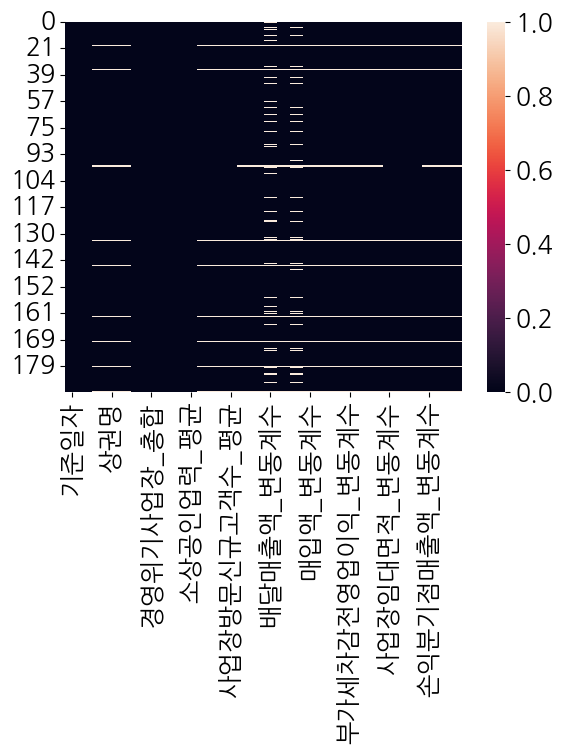

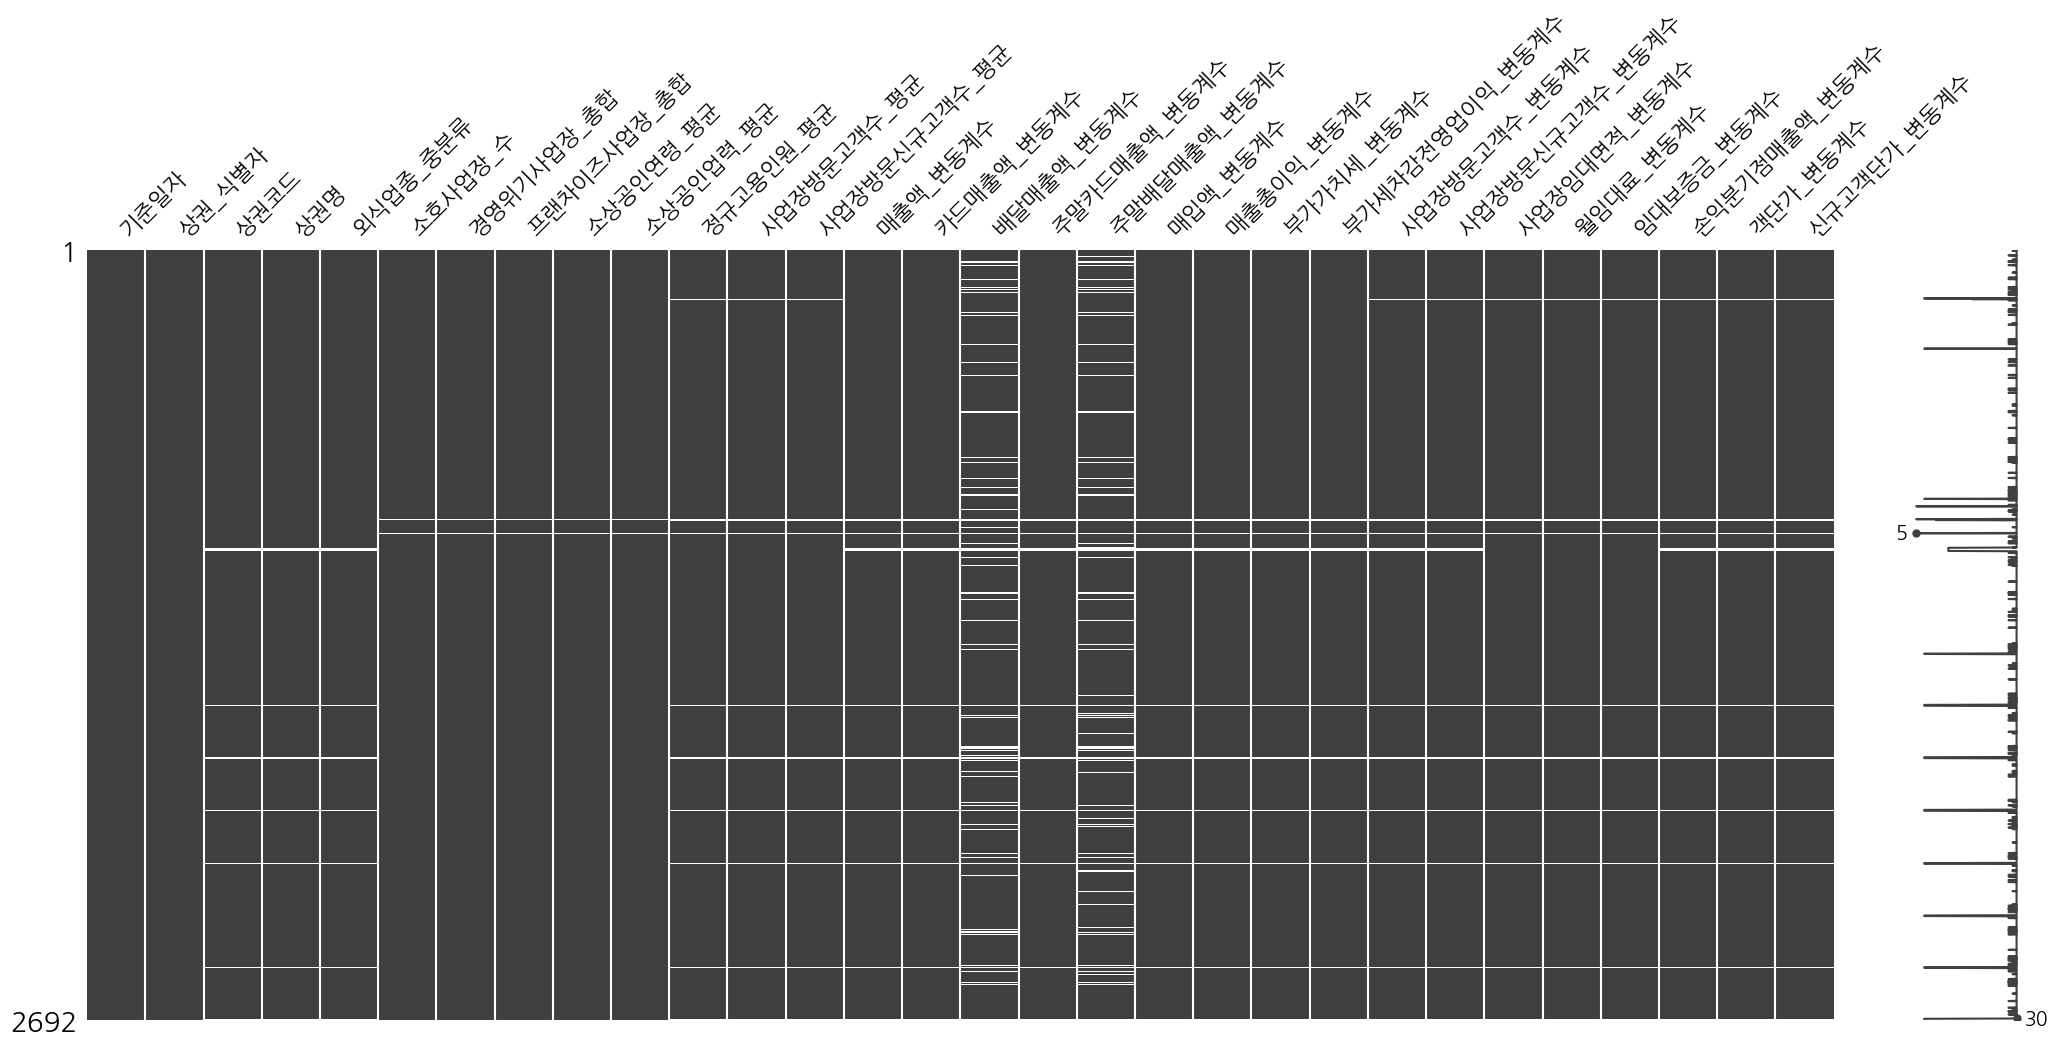

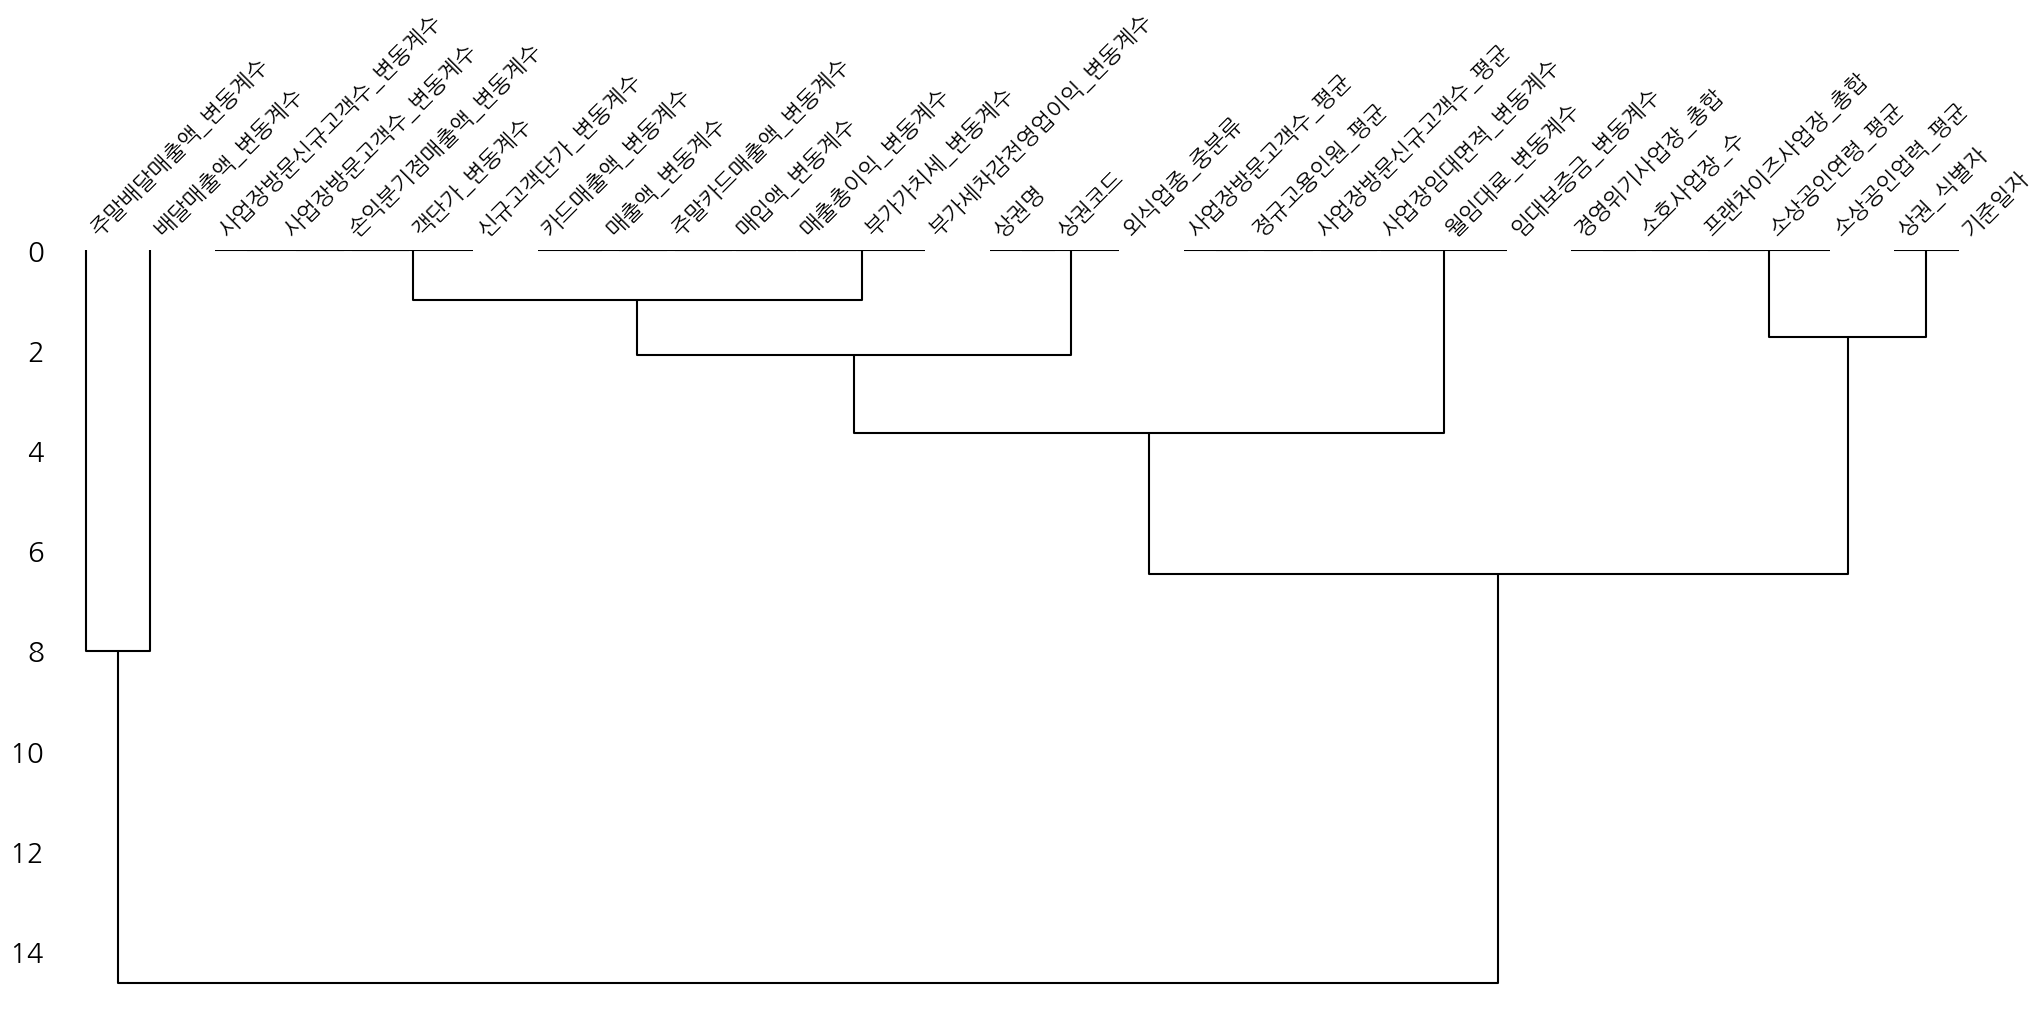

In [69]:
# 결측값 시각화
sns.heatmap(SOHO_MERGE_DATA.isnull(), cbar = True)
msno.matrix(SOHO_MERGE_DATA)
msno.dendrogram(SOHO_MERGE_DATA)

소호사업장_수


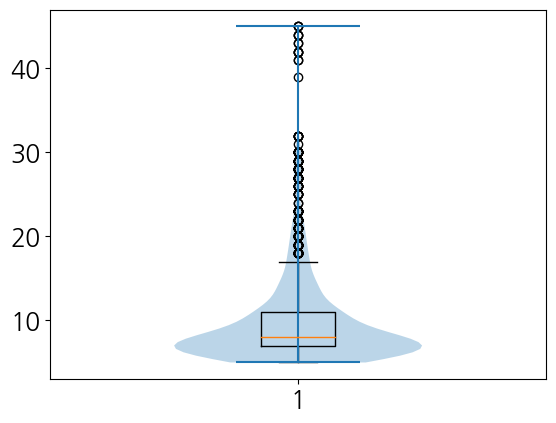

경영위기사업장_총합


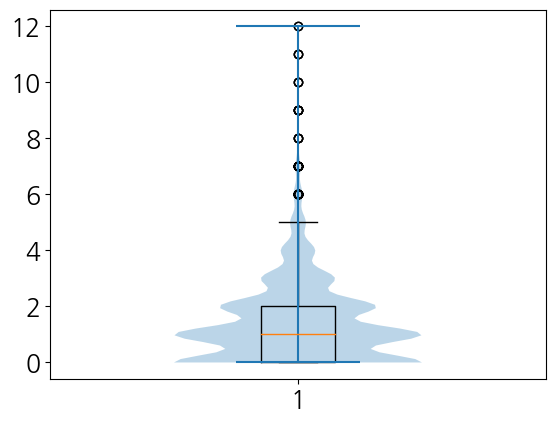

프랜차이즈사업장_총합


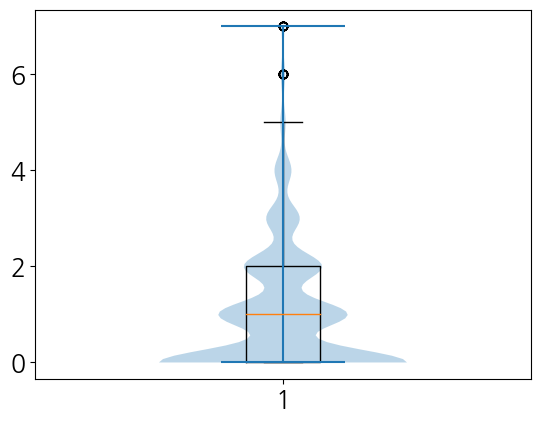

소상공인연령_평균


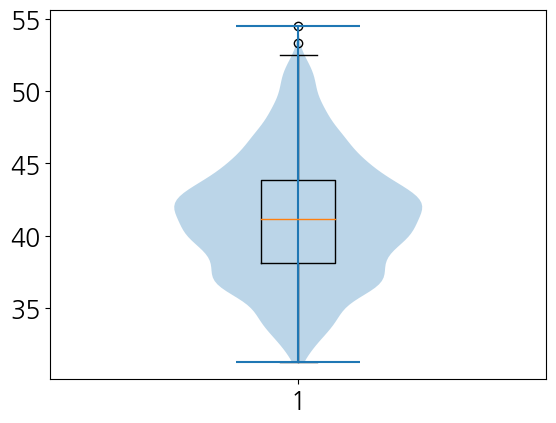

소상공인업력_평균


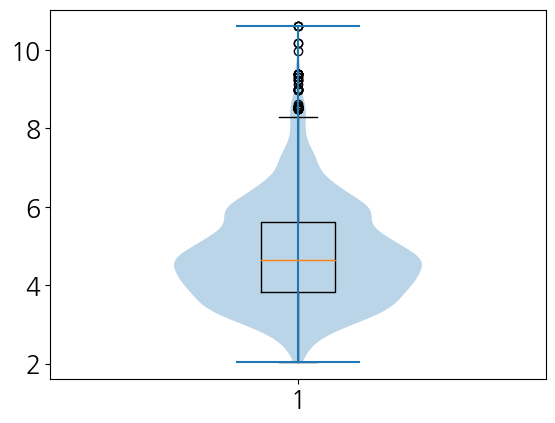

정규고용인원_평균


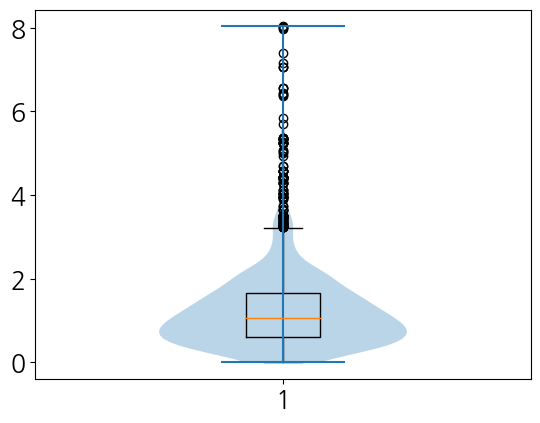

사업장방문고객수_평균


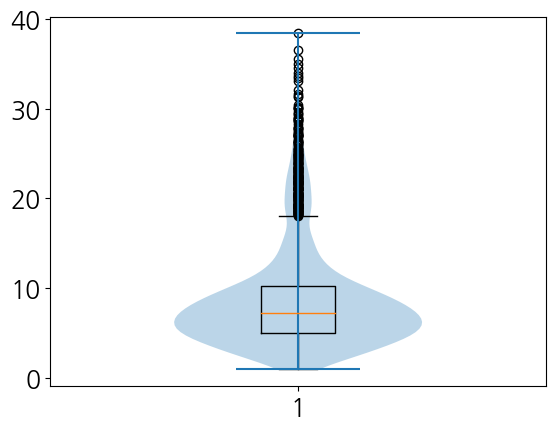

사업장방문신규고객수_평균


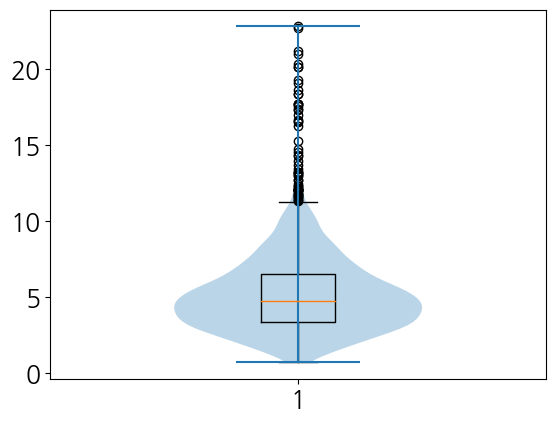

매출액_변동계수


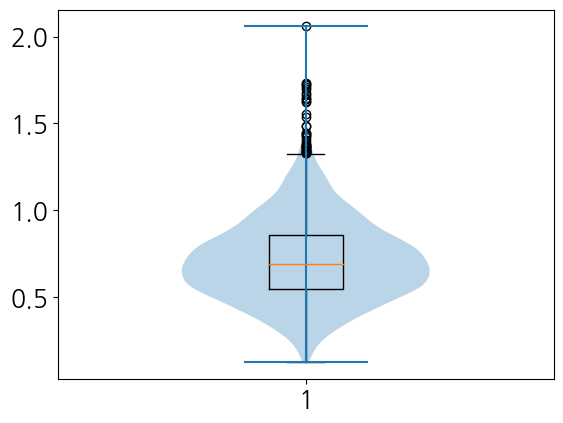

카드매출액_변동계수


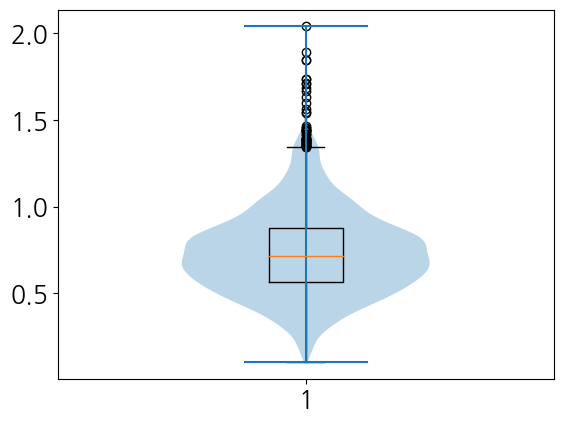

배달매출액_변동계수


/usr/local/lib/python3.10/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.10/dist-packages/matplotlib/mlab.py:978: RuntimeWarning: invalid value encountered in subtract
  diff = self.dataset - points[:, i, np.newaxis]
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


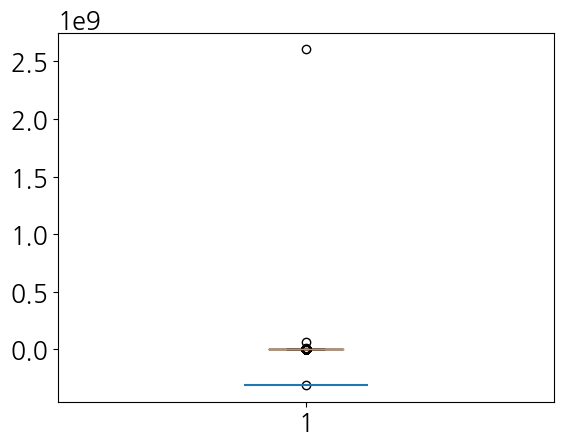

주말카드매출액_변동계수


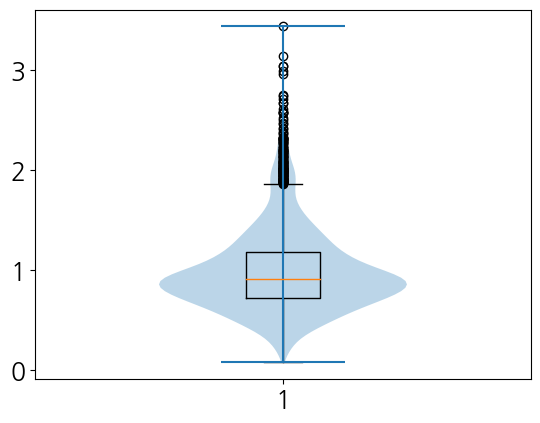

주말배달매출액_변동계수


/usr/local/lib/python3.10/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python3.10/dist-packages/matplotlib/mlab.py:978: RuntimeWarning: invalid value encountered in subtract
  diff = self.dataset - points[:, i, np.newaxis]
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


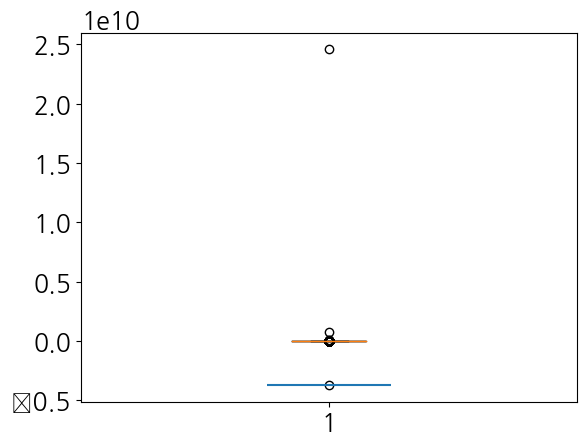

매입액_변동계수


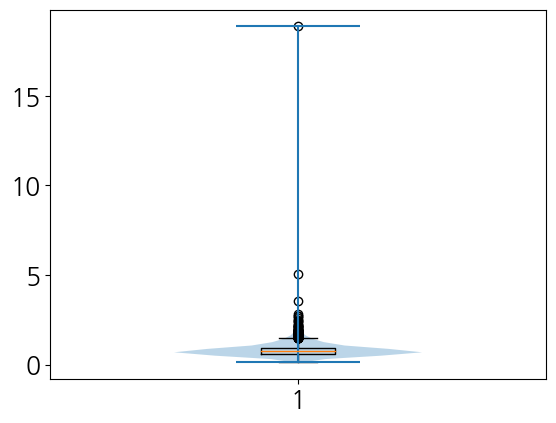

매출총이익_변동계수


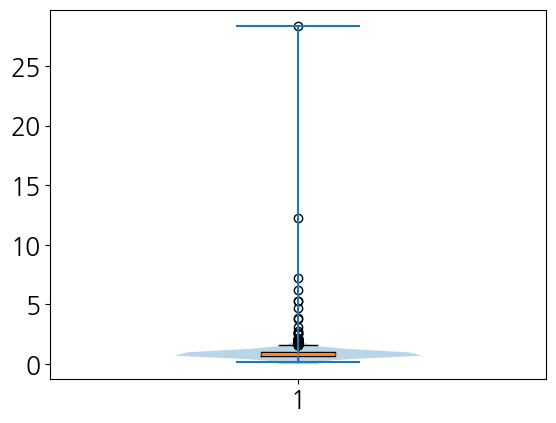

부가가치세_변동계수


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


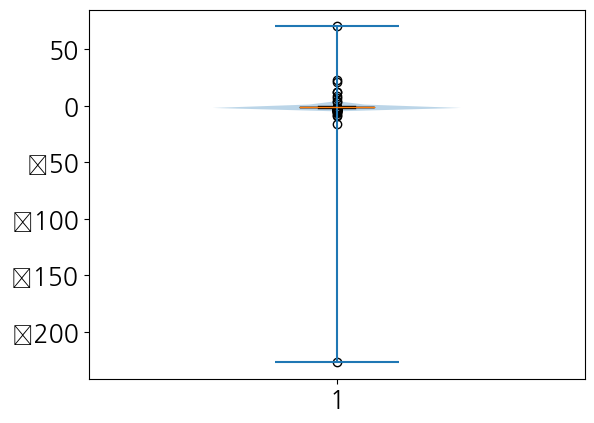

부가세차감전영업이익_변동계수


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


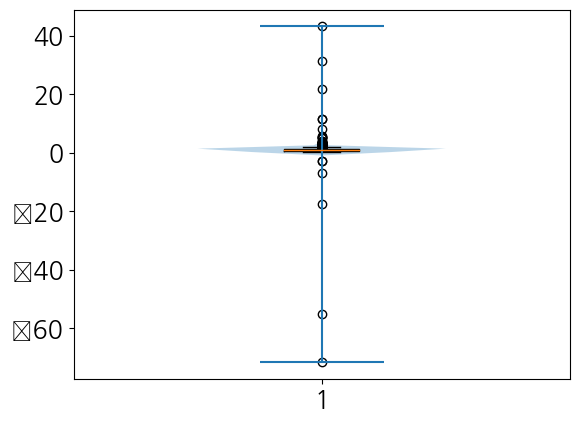

사업장방문고객수_변동계수


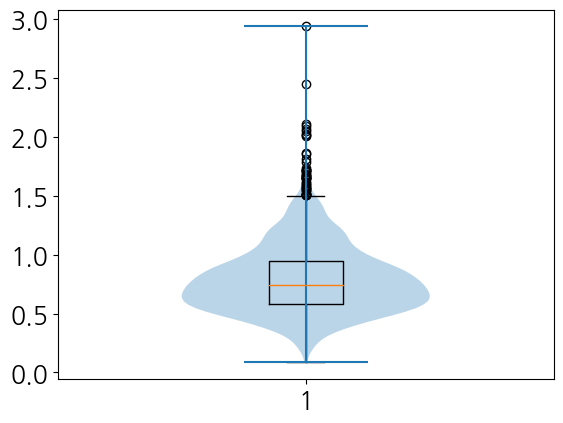

사업장방문신규고객수_변동계수


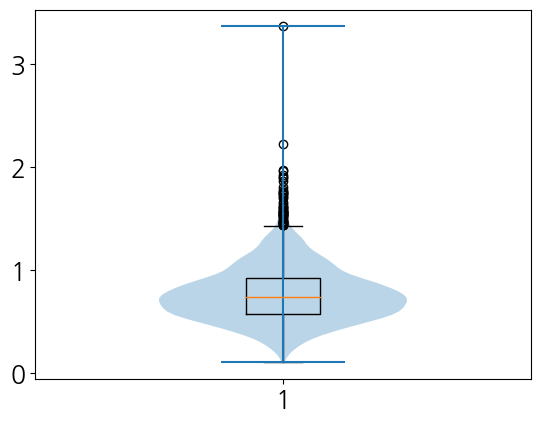

사업장임대면적_변동계수


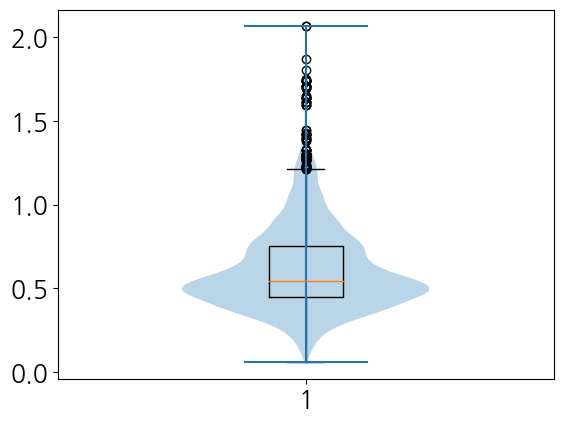

월임대료_변동계수


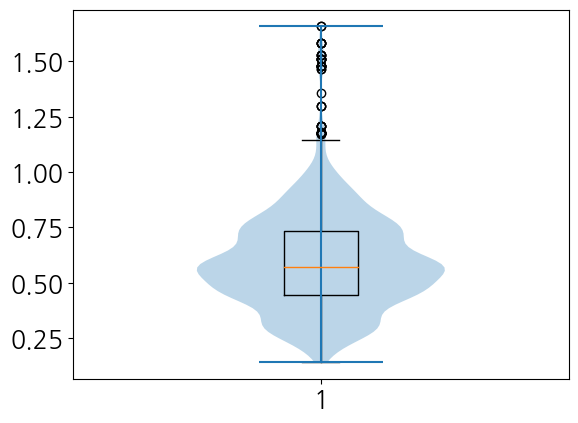

임대보증금_변동계수


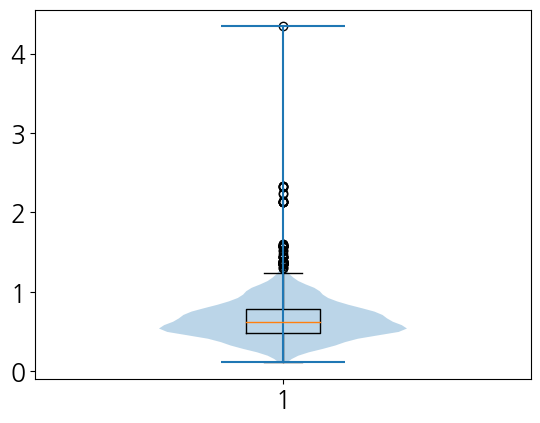

손익분기점매출액_변동계수


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


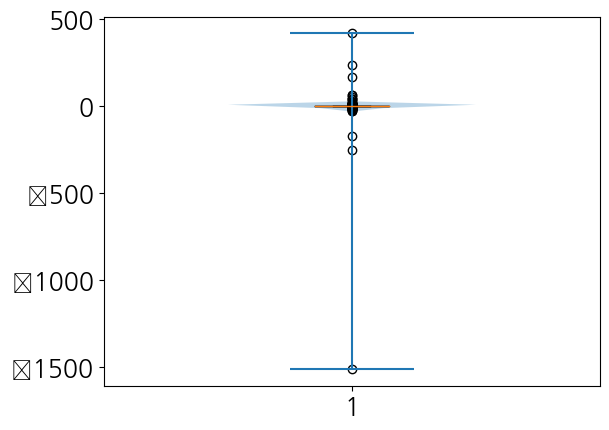

객단가_변동계수


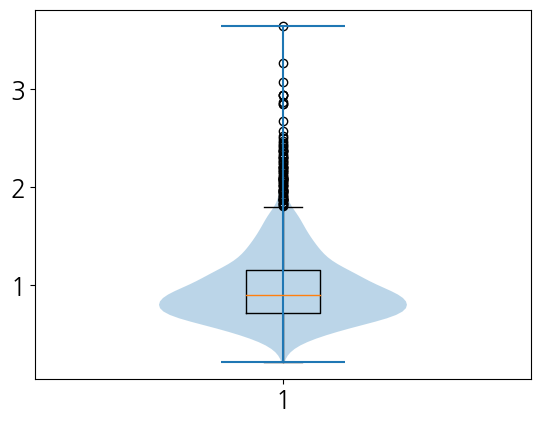

신규고객단가_변동계수


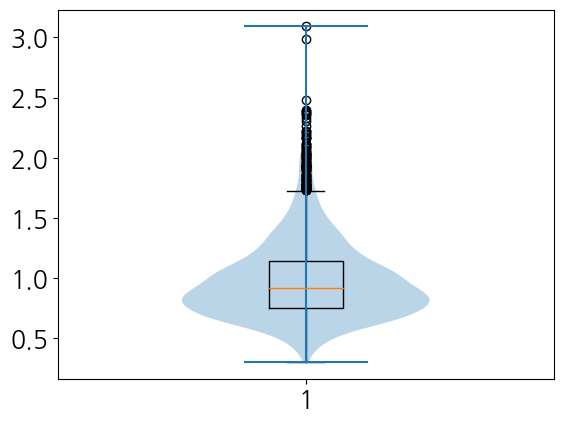

In [62]:
for column in SOHO_MERGE_DATA.select_dtypes(include = ["float", "integer"]).drop(["기준일자"], axis = 1).columns:
  print(column)
  plt.boxplot(SOHO_MERGE_DATA[column].dropna())
  plt.violinplot(SOHO_MERGE_DATA[column].dropna())
  plt.show()
  # display(SOHO_MERGE_DATA[column].describe())

___

In [18]:
# 1분기 매출액 표준편차
SOHO_INCOME_DATA_LIST[0]["매출액_표준편차"] + SOHO_INCOME_DATA_LIST[1]["매출액_표준편차"] + SOHO_INCOME_DATA_LIST[2]["매출액_표준편차"] / 3

0     17.0433
1     49.7787
10    92.0400
100   33.3979
101   32.0119
        ...  
95    28.2395
96    92.7059
97    37.3314
98    62.1453
99    50.6595
Name: 매출액_표준편차, Length: 175, dtype: float64

In [19]:
SOHO_INCOME_20221Q = pd.read_csv(
    "/content/drive/MyDrive/2023BigContest/data/DESILO_PLATFORM_DATA/SOHO_QUARTER_INCOME/SOHO_20221Q_INCOME_230916.csv",
    index_col = 0)
# 1분기 매출액 표준편차
SOHO_INCOME_20221Q["standard_deviation_population(kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery)"]

index
0      7.6353
1      6.6583
2     40.6041
3     25.5535
4     21.6640
        ...  
180   18.5748
181   12.9417
182   27.1207
183    7.8712
184   15.7737
Name: standard_deviation_population(kcd.transactions.sum_sales_card + kcd.transactions.sum_sales_delivery), Length: 185, dtype: float64

### 3.오아시스비즈니스(부동산 플랫폼 기업)의 서울특별시 고유필지단위별 소상공인의 매출등급 데이터에 상권코드, 법정동읍면동코드, 행정동코드 등 다른 테이블과의 병합(JOIN) 키로 활용될 컬럼 병합

* soho_sales_grade_list

  2022년 11개월의 서울특별시 고유필지단위별 소상공인의 매출등급 데이터를 담은 리스트 반환

* self.soho_commerce_data

  2022년 12개월의 소호 상권별 신용거래정보 데이터프레임을 담은 리스트와 2022년 11개월의 서울특별시 고유필지단위별 소상공인의 매출등급 데이터를 담은 리스트에서 원소(월별 데이터프레임)를 하나씩 꺼내어 병합하는 작업 11회 반복

In [83]:
class LoadData():

  def __init__(self,
               commerce_district_data_path: str, commerce_district_data = None, soho_commerce_data = None):
    # 생성자를 활용하여 초기화하고 클래스 내부에 캡슐화

    commerce_district_data_chunk = pd.read_csv(
        commerce_district_data_path, chunksize = 10**5,
        index_col = False, na_values = "NaN", encoding = "cp949")
    commerce_district_data_list = list(commerce_district_data_chunk)
      # 용량이 큰 csv 파일 읽어오기(fopen - fread와 유사한 방식)
    self.commerce_district_data = pd.concat(commerce_district_data_list)
    self.soho_commerce_data = soho_commerce_data


  def chunkDataMerge(self, column_name_list: List):
                     # , codebook_filepath: str, district_file_path: str, left_join_key1: str, right_join_key1: str, left_join_key2: str, right_join_key2: str):
    self.commerce_district_data.columns = column_name_list

    # codebook = pd.read_csv(codebook_filepath, index_col = False, encoding = "euc-kr")
    # district_code = pd.read_csv(district_file_path, index_col = False, encoding = "euc-kr")

    # self.commerce_district_data = pd.merge(left = self.commerce_district_data, right = codebook, left_on = left_join_key1, right_on = right_join_key1, how = "left")
    # self.commerce_district_data.drop(right_join_key1, axis = 1, inplace = True)
    # self.commerce_district_data = pd.merge(
        # left = self.commerce_district_data, right = district_code[["상권_구분_코드_명", "상권_코드", "상권_코드_명"]],
        # left_on = left_join_key2, right_on = right_join_key2, how = "left")

    return self.commerce_district_data


  def splitMonthlyData(self, month: int):
    soho_sales_grade_list: List = []
    while month < 202213:
      soho_sales_grade_list.append(
          self.commerce_district_data.loc[self.commerce_district_data["데이터기준연월"] == month])
      month += 1

    return soho_sales_grade_list


  def mergeData(self, soho_credit_list: List, sales_grade_list: List,
                left_join_key: str, right_join_key: str):
    self.soho_commerce_data: List = []
    for index in range(0, 11, 1):
      self.soho_commerce_data(
          pd.merge(left = soho_credit_list[index], right = sales_grade_list[index],
                  left_on = left_join_key, right_on = right_join_key, how = "left"))

    return self.soho_commerce_data

In [84]:
soho_sales_grade = LoadData(commerce_district_data_path = "/content/drive/MyDrive/2023BigContest/data/contest data/필지단위 소상공인 매출등급 정보.csv")

In [85]:
soho_sales_grade.chunkDataMerge(column_name_list = ["데이터기준연월", "필지고유번호", "법정동읍면동코드", "업종코드", "매출등급"])

,데이터기준연월,필지고유번호,법정동읍면동코드,업종코드,매출등급
0,202201,1111010000000000000.0000,11110101,A03,4
1,202201,1111010000000000000.0000,11110101,A01,2
2,202201,1111010000000000000.0000,11110101,A11,3
3,202201,1111010000000000000.0000,11110101,A03,2
4,202201,1111010000000000000.0000,11110101,A01,2
...,...,...,...,...,...
1048570,202211,1168010000000000000.0000,11680108,A01,1
1048571,202211,1168010000000000000.0000,11680108,A13,3
1048572,202211,1168010000000000000.0000,11680108,A01,1
1048573,202211,1168010000000000000.0000,11680108,A01,2


```
STDG_EMD_CD_codebook = pd.read_excel(
    "/content/drive/MyDrive/2023BigContest/data/대회제공/소상공인 매출등급 예상 대상 필지.xlsx",
    sheet_name = 0,
    index_col = None)
STDG_EMD_CD_codebook.drop(["SLS_GRD_2301", "SLS_GRD_2302"], axis = 1, inplace = True)
  # [법정동읍면동코드] 시, 구 아래에 두며 그 아래에는 통과 반이 있는, 법률로 지정한 행정 구역의 정보를 나타내는 기호 체계
  # 법정동(10자리)의 구성: 광역시(2자리)+시군구(3자리)+읍면동(3자리)+리(2자리)
  # 법정동코드 10자리 중 앞6번째부터 8번째자리(101:청운동, 101:신교동…)
display(STDG_EMD_CD_codebook)
  # 고유식별자는 총 10,000행
  # [매출등급] 특정 필지의 '평당추정매출/평당월임대료'
```

In [ ]:
"""
soho_commerce_merge_data = soho_sales_grade.mergeData(
    soho_credit_list = SOHO_MERGE_DATA, sales_grade_list = soho_sales_grade_list,
    left_join_key = "상권코드", right_join_key = "상권_코드")
"""

```
# VarianceInflationFactor()
# VIF(분산팽창인자) 값에 따른 최소한 모형 적합 시 입력할 독립변수의 수 파악을 위한 반복문 수행
  def VarainceInflationFactor(self,
                              X_train_data: pd.DataFrame(), X_test_data: pd.DataFrame(),
                              # num_variables: int,
                              Y_train_data: pd.DataFrame(), Y_test_data: pd.DataFrame()):

    evaluation_train = pd.DataFrame()
    evaluation_test = pd.DataFrame()

    for index in tqdm( range(1, len(X_train_data.columns) + 1)):

    # 분산팽창인자를 피처 수별로 구한 후 오름차순하여 vif 데이터프레임에 저장(다중공선성 문제로 나머지 변수 제외)
    # X_train_data에서 변수 index 수만큼의 피처(독립변수)만 남기고 나머지 변수 제외하여 X_train_fe_scaling_multiple 생성
    # X_train_test도 이하 상동
      vif = pd.DataFrame()
      vif["VIF_factor"] = [variance_inflation_factor(X_train_data.values, index)
                          for index in range(X_train_data.shape[1]) ]
      vif["Features"] = X_train_data.columns
      # print(vif)
      X_column_vif = vif.sort_values(by = "VIF_factor", ascending = True)["Features"][:index].values
        # TypeError: 'NoneType' object is not subscriptable

      X_train_fe_scaling_multiple, X_test_fe_scaling_multiple = X_train_data[X_column_vif].copy(), X_test_data[X_column_vif].copy()
```

### 4.분기별 상권특성 공공데이터 로드

* 상권_아파트
```
SELECT AVERAGE(seoul.상권특성.아파트_단지_수), AVERAGE(seoul.상권특성.아파트_가격_1_억_미만_세대_수), AVERAGE(seoul.상권특성.아파트_가격_1_억_세대_수), AVERAGE(seoul.상권특성.아파트_가격_2_억_세대_수), AVERAGE(seoul.상권특성.아파트_가격_3_억_세대_수), AVERAGE(seoul.상권특성.아파트_가격_4_억_세대_수), AVERAGE(seoul.상권특성.아파트_가격_5_억_세대_수), AVERAGE(seoul.상권특성.아파트_가격_6_억_이상_세대_수), COUNT(*), SUM(kcd.meta-info.is_franchise)
FROM kcd.meta-info
JOIN seoul.상권특성
ON kcd.meta-info.trdar_nm = seoul.상권특성.상권_코드_명
WHERE kcd.meta-info.class_1_name = "외식업"
GROUP BY seoul.상권특성.기준_년_코드, seoul.상권특성.기준_분기_코드, kcd.meta-info.class_2_name
```

* 상권_집객인구
```
SELECT AVERAGE(seoul.상권특성.집객시설_수), AVERAGE(seoul.상권특성.관공서_수), AVERAGE(seoul.상권특성.은행_수), AVERAGE(seoul.상권특성.종합병원_수), AVERAGE(seoul.상권특성.일반_병원_수), AVERAGE(seoul.상권특성.약국_수), AVERAGE(seoul.상권특성.유치원_수), AVERAGE(seoul.상권특성.초등학교_수), AVERAGE(seoul.상권특성.고등학교_수), AVERAGE(seoul.상권특성.대학교_수), AVERAGE(seoul.상권특성.백화점_수), AVERAGE(seoul.상권특성.슈퍼마켓_수), AVERAGE(seoul.상권특성.숙박_시설_수), AVERAGE(seoul.상권특성.버스_터미널_수), AVERAGE(seoul.상권특성.지하철_역_수), AVERAGE(seoul.상권특성.버스_정거장_수), COUNT(*), SUM(kcd.meta-info.is_franchise)
FROM kcd.meta-info
JOIN seoul.상권특성
ON kcd.meta-info.trdar_no = seoul.상권특성.상권_코드
WHERE kcd.meta-info.class_1_name = "외식업"
GROUP BY seoul.상권특성.기준_년_코드, seoul.상권특성.기준_분기_코드, kcd.meta-info.class_2_name
```

* 상권_점포
```
SELECT AVERAGE(seoul.상권특성.개업_점포_수), AVERAGE(seoul.상권특성.유사_업종_점포_수), AVERAGE(seoul.상권특성.폐업_점포_수), AVERAGE(seoul.상권특성.점포_수), AVERAGE(seoul.상권특성.프랜차이즈_점포_수), STANDARD_DEVIATION_POPULATION(seoul.상권특성.개업_율), STANDARD_DEVIATION_POPULATION(seoul.상권특성.폐업_율), COUNT(*), SUM(kcd.meta-info.is_franchise)
FROM kcd.meta-info
JOIN seoul.상권특성
ON kcd.meta-info.trdar_nm = seoul.상권특성.상권_코드_명
WHERE kcd.meta-info.class_1_name = "외식업"
GROUP BY seoul.상권특성.기준_년_코드, seoul.상권특성.기준_분기_코드, kcd.meta-info.class_2_name
```

* 상권_소득소비
```
SELECT AVERAGE(seoul.상권특성.교육_지출_총금액), AVERAGE(seoul.상권특성.교통_지출_총금액), AVERAGE(seoul.상권특성.생활용품_지출_총금액), AVERAGE(seoul.상권특성.문화_지출_총금액), AVERAGE(seoul.상권특성.유흥_지출_총금액), AVERAGE(seoul.상권특성.의료비_지출_총금액), AVERAGE(seoul.상권특성.의류_신발_지출_총금액), AVERAGE(seoul.상권특성.식료품_지출_총금액), AVERAGE(seoul.상권특성.여가_지출_총금액), COUNT(*), SUM(kcd.meta-info.is_franchise)
FROM kcd.meta-info
JOIN seoul.상권특성
ON kcd.meta-info.trdar_no = seoul.상권특성.상권_코드
WHERE kcd.meta-info.class_1_name = "외식업"
GROUP BY seoul.상권특성.기준_년_코드, seoul.상권특성.기준_분기_코드, kcd.meta-info.class_2_name
```

* 상권_상주인구
```
SELECT AVERAGE(seoul.상권특성.연령대_10_상주인구_수), AVERAGE(seoul.상권특성.연령대_20_상주인구_수), AVERAGE(seoul.상권특성.연령대_30_상주인구_수), AVERAGE(seoul.상권특성.연령대_40_상주인구_수), AVERAGE(seoul.상권특성.연령대_50_상주인구_수), AVERAGE(seoul.상권특성.연령대_60_이상_상주인구_수), AVERAGE(seoul.상권특성.총_가구_수), AVERAGE(seoul.상권특성.비_아파트_가구_수), AVERAGE(seoul.상권특성.아파트_가구_수), AVERAGE(seoul.상권특성.총_상주인구_수), AVERAGE(seoul.상권특성.남성_상주인구_수), AVERAGE(seoul.상권특성.여성_상주인구_수), COUNT(*), SUM(kcd.meta-info.is_franchise)
FROM kcd.meta-info
JOIN seoul.상권특성
ON kcd.meta-info.trdar_no = seoul.상권특성.상권_코드
WHERE kcd.meta-info.class_1_name = "외식업"
GROUP BY seoul.상권특성.기준_년_코드, seoul.상권특성.기준_분기_코드, kcd.meta-info.class_2_name
```

* 상권_직장인구
```
SELECT AVERAGE(seoul.상권특성.남성_직장_인구_수), AVERAGE(seoul.상권특성.여성_직장_인구_수), AVERAGE(seoul.상권특성.연령대_10_직장_인구_수), AVERAGE(seoul.상권특성.연령대_20_직장_인구_수), AVERAGE(seoul.상권특성.연령대_30_직장_인구_수), AVERAGE(seoul.상권특성.연령대_50_직장_인구_수), AVERAGE(seoul.상권특성.연령대_40_직장_인구_수), AVERAGE(seoul.상권특성.연령대_60_이상_직장_인구_수), AVERAGE(seoul.상권특성.총_직장_인구_수), COUNT(*), SUM(kcd.meta-info.is_franchise)
FROM kcd.meta-info
JOIN seoul.상권특성
ON kcd.meta-info.trdar_no = seoul.상권특성.상권_코드
WHERE kcd.meta-info.class_1_name = "외식업"
GROUP BY seoul.상권특성.기준_년_코드, seoul.상권특성.기준_분기_코드, kcd.meta-info.class_2_name
```

In [102]:
def readDataFile(file_path: str, unicode: str):
  dataframe = pd.read_csv(file_path, index_col = False, na_values = "NaN", encoding = unicode)
  return dataframe

In [103]:
MARKET_2022 = readDataFile(file_path = "/content/drive/MyDrive/2023BigContest/data/MERGE_DATA/market_2022.csv", unicode = "cp949")
MARKET_2023 = readDataFile(file_path = "/content/drive/MyDrive/2023BigContest/data/MERGE_DATA/market_2023.csv", unicode = "cp949")
MARKET_CONTEST_2022 = readDataFile(file_path = "/content/drive/MyDrive/2023BigContest/data/MERGE_DATA/market_contest_2022.csv", unicode = "cp949")
MARKET_CONTEST_2023 = readDataFile(file_path = "/content/drive/MyDrive/2023BigContest/data/MERGE_DATA/market_contest_2023.csv", unicode = "cp949")

<ipython-input-102-82b3acc23bd9>:2: DtypeWarning: Columns (2,3,5,19,20,43,61,62,121,122) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(file_path, index_col = False, na_values = "NaN", encoding = unicode)
<ipython-input-102-82b3acc23bd9>:2: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(file_path, index_col = False, na_values = "NaN", encoding = unicode)


In [104]:
MARKET_2022

,기준_년_코드_x,기준_분기_코드,상권_구분_코드,상권_구분_코드_명_x,상권_코드,상권_코드_명_x,월_평균_소득_금액_x,소득_구간_코드_x,지출_총금액_x,식료품_지출_총금액_x,의류_신발_지출_총금액_x,생활용품_지출_총금액_x,의료비_지출_총금액_x,교통_지출_총금액_x,여가_지출_총금액_x,문화_지출_총금액_x,교육_지출_총금액_x,유흥_지출_총금액_x,기준_년_코드_y,상권_구분_코드_명,상권_코드_명_y,총_생활인구_수_x,남성_생활인구_수_x,여성_생활인구_수_x,연령대_10_생활인구_수_x,연령대_20_생활인구_수_x,연령대_30_생활인구_수_x,연령대_40_생활인구_수_x,연령대_50_생활인구_수_x,연령대_60_이상_생활인구_수_x,시간대_1_생활인구_수_x,시간대_2_생활인구_수_x,시간대_3_생활인구_수_x,시간대_4_생활인구_수_x,시간대_5_생활인구_수_x,시간대_6_생활인구_수_x,월요일_생활인구_수_x,화요일_생활인구_수_x,수요일_생활인구_수_x,목요일_생활인구_수_x,금요일_생활인구_수_x,토요일_생활인구_수_x,일요일_생활인구_수_x,상권_구분_코드_명_y,총_직장_인구_수_x,남성_직장_인구_수_x,여성_직장_인구_수_x,연령대_10_직장_인구_수_x,연령대_20_직장_인구_수_x,연령대_30_직장_인구_수_x,연령대_40_직장_인구_수_x,연령대_50_직장_인구_수_x,연령대_60_이상_직장_인구_수_x,아파트_단지_수_x,아파트_가격_1_억_미만_세대_수_x,아파트_가격_1_억_세대_수_x,아파트_가격_2_억_세대_수_x,아파트_가격_3_억_세대_수_x,아파트_가격_4_억_세대_수_x,아파트_가격_5_억_세대_수_x,아파트_가격_6_억_이상_세대_수_x,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,월_평균_소득_금액_y,소득_구간_코드_y,지출_총금액_y,식료품_지출_총금액_y,의류_신발_지출_총금액_y,생활용품_지출_총금액_y,의료비_지출_총금액_y,교통_지출_총금액_y,여가_지출_총금액_y,문화_지출_총금액_y,교육_지출_총금액_y,유흥_지출_총금액_y,총_생활인구_수_y,남성_생활인구_수_y,여성_생활인구_수_y,연령대_10_생활인구_수_y,연령대_20_생활인구_수_y,연령대_30_생활인구_수_y,연령대_40_생활인구_수_y,연령대_50_생활인구_수_y,연령대_60_이상_생활인구_수_y,시간대_1_생활인구_수_y,시간대_2_생활인구_수_y,시간대_3_생활인구_수_y,시간대_4_생활인구_수_y,시간대_5_생활인구_수_y,시간대_6_생활인구_수_y,월요일_생활인구_수_y,화요일_생활인구_수_y,수요일_생활인구_수_y,목요일_생활인구_수_y,금요일_생활인구_수_y,토요일_생활인구_수_y,일요일_생활인구_수_y,총_직장_인구_수_y,남성_직장_인구_수_y,여성_직장_인구_수_y,연령대_10_직장_인구_수_y,연령대_20_직장_인구_수_y,연령대_30_직장_인구_수_y,연령대_40_직장_인구_수_y,연령대_50_직장_인구_수_y,연령대_60_이상_직장_인구_수_y,아파트_단지_수_y,아파트_가격_1_억_미만_세대_수_y,아파트_가격_1_억_세대_수_y,아파트_가격_2_억_세대_수_y,아파트_가격_3_억_세대_수_y,아파트_가격_4_억_세대_수_y,아파트_가격_5_억_세대_수_y,아파트_가격_6_억_이상_세대_수_y,상권_구분_코드_명,상권_코드_명,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,초등학교_수,중학교_수,고등학교_수,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수,기준_월,기준_년월_코드,행정동_코드,법정동_코드,STDG_EMD_CD
0,2022,4,A,골목상권,2110001,이북5도청사,4305934.0000,8.0000,520427635.0000,129126028.0000,64853632.0000,37122367.0000,65974602.0000,88343761.0000,22223650.0000,14656697.0000,76185341.0000,21941557.0000,2022,골목상권,이북5도청사,179890,77520,102371,32520,19380,18694,27893,28419,52986,46661,38082,20225,21164,29951,23808,25766,24959,24786,25388,24645,26979,27365,골목상권,1066,638,428,4,133,292,240,262,135,21,11.0000,4.0000,35.0000,105.0000,111.0000,25.0000,59.0000,CS300043,전자상거래업,1,1,0,0,0,0,0,4054707,8,2580948514.0000,649751401.0000,320015034.0000,187832611.0000,334420012.0000,442214143.0000,106952810.0000,73437612.0000,356342314.0000,109982577.0000,432784,190019,242766,80060,48620,44528,66774,67999,124803,118105,89017,47135,48403,71103,59021,61746,60804,60566,61116,60354,63801,64399,5968,4230,1738,11,1084,1435,1383,1526,529,114,17,127,274,314,210,150,207,골목상권,이북5도청사,42,2.0000,NaN,NaN,NaN,2.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,12,202212,11110560,11110182,11110182
1,2022,4,A,골목상권,2110001,이북5도청사,4305934.0000,8.0000,520427635.0000,129126028.0000,64853632.0000,37122367.0000,65974602.0000,88343761.0000,22223650.0000,14656697.0000,76185341.0000,21941557.0000,2022,골목상권,이북5도청사,179890,77520,102371,32520,19380,18694,27893,28419,52986,46661,38082,20225,21164,29951,23808,25766,24959,24786,25388,24645,26979,27365,골목상권,1066,638,428,4,133,292,240,262,135,21,11.0000,4.0000,35.0000,105.0000,111.0000,25.0000,59.0000,CS300043,전자상거래업,1,1,0,0,0,0,0,4054707,8,2580948514.0000,649751401.0000,320015034.0000,187832611.0000,334420012.0000,442214143.0000,106952810.0000,73437612.0000,356342314.0000,109982577.0000,432784,190019,242766,80060,48620,44528,66774,67999,124803,118105,89017,47135,48403,71103,59021,61746,60804,60566,61116,60354,63801,64399,5968,4230,1738,11,1084,1435,1383,1526,529,114,17,127,274,314,210,150,207,골목상권,이북5도청사,42,2.0000,NaN,NaN,NaN,2.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,12,202212,11110560,11110183,11110183
2,2022,4,A,골목상권,2110001,이북5도청사,4305934.0000,8.0000,520427635.0000,129126028.0000,64853632.0000,37122367.0000,65974602.0000,88343761.0000,22223650.0000,14656697.0000,76185341.0000

In [108]:
_, column_num = MARKET_CONTEST_2022.shape

for index in range(0, 10, 1):
  if index <= column_num:
    MARKET_CONTEST_2022.iloc[:, index: index + 30].info()
    index += 30
  else:
    break

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   기준_년_코드_x           547674 non-null  float64
 1   기준_분기_코드            547674 non-null  float64
 2   상권_구분_코드            547674 non-null  object 
 3   상권_구분_코드_명_x        547674 non-null  object 
 4   상권_코드               547674 non-null  float64
 5   상권_코드_명_x           547674 non-null  object 
 6   월_평균_소득_금액_x        547674 non-null  float64
 7   소득_구간_코드_x          547674 non-null  float64
 8   지출_총금액_x            547674 non-null  float64
 9   식료품_지출_총금액_x        547674 non-null  float64
 10  의류_신발_지출_총금액_x      547674 non-null  float64
 11  생활용품_지출_총금액_x       547674 non-null  float64
 12  의료비_지출_총금액_x        547674 non-null  float64
 13  교통_지출_총금액_x         547674 non-null  float64
 14  여가_지출_총금액_x         547674 non-null  float64
 15  문화_지출_총금액_x         547674 non-n